In [1]:
import requests
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
import pandas as pd
import csv
import time
import operator
import re

In [2]:
#m_url ="https://www.nytimes.com/topic/subject/construction-accidents"
m_url ="https://www.nytimes.com/search?dropmab=false&endDate=20200229&query=%22construction%22%20accident&sort=best&startDate=20000101"






In [3]:
session = requests.Session()
req=session.get(m_url) #default is s_url
soup = BeautifulSoup(req.text, 'html.parser')

#stream-panel > div.css-13mho3u > ol > li:nth-child(2) > div > div.css-1l4spti > a
#stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a


In [6]:

chrome_options = webdriver.ChromeOptions
#chrome_options.add_argument("--incognito")
driver = webdriver.Chrome(executable_path='/Users/macbookpro/Desktop/Project/Construction_analysis/chromedriver')

link = []
driver.get(m_url)
time.sleep(3)
for i in range(100) :
    a = driver.page_source
    b = BeautifulSoup(a, 'html.parser')
    #stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a
    #stream-panel > div.css-13mho3u > ol > li > div > div.css-1l4spti > a
    #site-content > div > div:nth-child(2) > div.css-46b038 > ol > li:nth-child(1) > div > div > div > a
    c = b.select('#site-content > div >div>div> ol >li> div > div > div > a')
    
    for j in range(len(c)) :
        if c[j].attrs['href'] not in link :
            link.append(c[j].attrs['href'])
        else :
            pass
    
    driver.find_element_by_xpath('//*[@id="site-content"]/div/div[2]/div[2]/div/button').click()
    time.sleep(3)

#link

In [7]:
link_source = link 

a_link = link

print(len(a_link))


1000


In [8]:
diff_link = []

#delete unsupported news 
for i in range (len(a_link)) :
    print(a_link[i])
    if a_link[i][1] != '2':
        
        diff_link.append(a_link[i])
            
    else : 
        continue

for j in range(len(diff_link)):
    if diff_link[j] in a_link:
        a_link.remove(diff_link[j])
        
#a_link


/2020/02/17/nyregion/construction-deaths-latinos-nyc.html?searchResultPosition=1
/2020/01/30/nyregion/nyc-scaffolding-building-facades.html?searchResultPosition=2
/2019/11/22/nyregion/nyc-dob-surprise-inspectors.html?searchResultPosition=3
/2019/11/29/us/hard-rock-hotel-worker-immigration.html?searchResultPosition=4
/2007/09/13/nyregion/13mbrfs-DEATHS.html?searchResultPosition=5
/2015/06/03/nyregion/fatal-construction-accidents-are-rising-in-new-york.html?searchResultPosition=6
/2006/11/22/nyregion/fatal-construction-accidents-in-the-city-rise-sharply-over-12.html?searchResultPosition=7
/2006/11/22/nyregion/22construct.html?searchResultPosition=8
/2007/05/05/nyregion/05cave.html?searchResultPosition=9
https://cityroom.blogs.nytimes.com/2008/04/29/more-construction-accidents-2-workers-critically-injured/?searchResultPosition=10
/2002/08/27/nyregion/city-allows-work-to-resume-at-construction-accident-site.html?searchResultPosition=11
https://cityroom.blogs.nytimes.com/2007/08/23/new-scaf

In [9]:
## This is main source for analyzing article

class ArticleInfo():
    
    def __init__(self, s_url) :
        
        session = requests.Session()
        req=session.get(s_url)
        self.soup = BeautifulSoup(req.text, 'html.parser')
    
    
    def article_body(self) :
        body = self.soup.find('div', {'class' : 'StoryBodyCompanionColumn'})
        finalContent =''
    
        if body is not None :
            for itcontents in self.soup.findAll('p'):
                if itcontents == None :
                    continue
                content = itcontents.getText()
                content = re.sub(r"\n+", "", content)
                finalContent +=content
        else :
            return False
        
        return finalContent

##reference: https://github.com/subhendusethi/nytimes-article-crawler/blob/master/crawler/nytimescrawler.py    

    def article_title(self):
        titles = self.soup.select('title',{"data-rh":"true"})
        for title in titles:
            title = title.getText()
            break
        return title

    def article_date(self) :
  
        date = self.soup.find('li',{'class':'date'})
        if date != None :
            date = date.getText()
            
        else :
            date = self.soup.find('meta',{'name':'pdate'})
            if date !=None :
                date = date.get('content')
                if date !=None :
                    date = str(date)
                else:
                    none= "none"
                    datelist.append(none)
                
        return date

 

In [10]:
titles =[]
bodies =[]
datelist=[]

for s_url in a_link :
    s_url = 'https://www.nytimes.com'+s_url
    ob = ArticleInfo(s_url)
    
    body =ob.article_body()
    bodies.append(body)
    
    date = ob.article_date()
    datelist.append(date)
    
    title = ob.article_title()
    titles.append(title)

In [452]:
#bodies

### Start Tokenize words with nltk

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.probability import ConditionalFreqDist
from gensim.models import Word2Vec


In [12]:

#1. make lower case, regulazation
l_bodies=[]
for body in bodies :
    
    body = str(body).lower()
    l_bodies.append(body)

    
#2. removing stop words, tokenize with postagging
stop_words = set(stopwords.words('english'))

token_sentence = []
for words in l_bodies:
    word_tokens= word_tokenize(words)
    filter_sentence = [fw for fw in word_tokens if not fw in stop_words]
    #filter_sentence = [fs for fs in word_tokens if not fs in remove_list]
    
    for n in range(len(filter_sentence)) :
        if filter_sentence[n] == 'collapsed' :
            filter_sentence[n]  = 'collapse'
        elif filter_sentence[n] == 'buildings':
            filter_sentence[n] = 'building'
        #elif filter_sentence[n] == 'fell' :
        #   filter_sentence[n] = 'fall'
       
    ## fall + fell => fall , collapsed +collapse => collapse
    #filter_sentence = nltk.pos_tag(filter_sentence)
    token_sentence.append(filter_sentence)
    
#token_sentence
#print(l_bodies)



In [13]:
len(token_sentence)

865

In [38]:
#frequency 

cnt_fire =0 
cnt_fall =0
cnt_collapse =0 
for token in token_sentence :
    if 'fire' in token :
        cnt_fire +=1
    if 'collapse' in token :
        cnt_collapse +=1
    if 'fell' in token :
        cnt_fall +=1

freq_dict = {}
freq_dict['fire'] = cnt_fire
freq_dict['fall'] = cnt_fall
freq_dict['collapse'] = cnt_collapse
print(cnt_fire, cnt_fall, cnt_collapse)
print(len(token_sentence))


193 236 281
865


{'fire': 193, 'fall': 236, 'collapse': 281}


<BarContainer object of 3 artists>

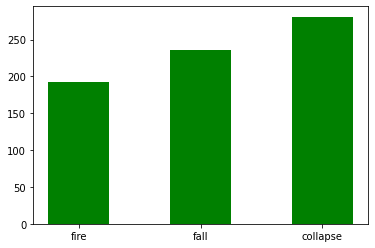

In [46]:
import matplotlib.pyplot as plt
print(freq_dict)
plt.bar(list(freq_dict.keys()),freq_dict.values(),width = 0.5, color ='g')

In [215]:
#print(sentences)
model = Word2Vec(token_sentence, size = 400, window=5, min_count=200, workers=3, sg=0, iter=5)

In [233]:
model.similarity('people','collapse')  ## similarity between words

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5233397

In [217]:
model.similarity('collapse','fell') 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.9313579

In [218]:
#model.most_similar('fire')
sim_list_fire = model.similar_by_vector('fire', topn=20, restrict_vocab=None)
sim_list_fall = model.similar_by_vector('fell', topn=20, restrict_vocab=None)
sim_list_collapse = model.similar_by_vector('collapse', topn=20, restrict_vocab=None)

print(sim_list_fire[1])

('cause', 0.8959450125694275)


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.


In [1831]:
df_sl = pd.DataFrame(sim_list)
df_sl
df_sl.to_csv('building_sim.csv')

In [226]:
sim_fire_word = []
for i in range(len(sim_list_fire)) :
    sim_fire_word.append(sim_list_fire[i][0])
print(sim_fire_word)

sim_fall_word = []
for i in range(len(sim_list_fall)) :
    sim_fall_word.append(sim_list_fall[i][0])
print(sim_fall_word)
sim_collapse_word =[]
for i in range(len(sim_list_collapse)):
    sim_collapse_word.append(sim_list_collapse[i][0])

['said.the', 'cause', 'authorities', 'investigators', 'police', 'scene', 'taken', 'floor', 'injuries', 'hospital', 'night', 'truck', 'debris', 'officials', 'spokesman', 'dead', 'yesterday', 'man', 'found', 'chief']
['east', 'west', 'side', 'collapse', 'brooklyn', 'park', 'street', 'avenue', 'friday', 'worker', 'second', 'morning', 'ground', 'across', 'death', 'floor', 'manhattan', 'occurred', 'injuries', 'debris']


In [1758]:
#data ={"Date":datelist, "Title": titles, "Body":bodies,"Link" :a_link}
#df= pd.DataFrame(data)

#df['Date']=pd.to_datetime(df.Date)
#df.sort_values(by='Date')
#df.to_excel('result_0301.xlsx')
#df.to_csv('/Users/macbookpro/Desktop/Project/Cosntruction_article/reslut_0301.csv', index= False,)


In [1759]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from umap import UMAP

In [208]:
reducer = UMAP(n_neighbors =5, min_dist =0.1, n_components = 2, verbose = True)

In [58]:
len(token_sentence)

865

In [209]:
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [210]:
#list of word

X_l = list(model.wv.vocab)
print(len(X_l))
#print(X_l)

294


In [171]:
# findout group
fire_group =[]
for i in range(len(sim_list_fire)) :
    fire_list = list(sim_list_fire[i])
    
    if  fire_list[0] in X_l :
        idx = X_l.index(fire_list[0])
        fire_group.append(idx)
        
print(fire_group)

fall_group = []
for j in range(len(sim_list_fall)) :
    fall_list = list(sim_list_fall[j])
    
    if fall_list[0] in X_l :
        idx = X_l.index(fall_list[0])
        fall_group.append(idx)
print(fall_group)

collapse_group = []
for k in range(len(sim_list_collapse)):
    collapse_list = list(sim_list_collapse[k])
    
    if collapse_list[0] in X_l :
        idx = X_l.index(collapse_list[0])
        collapse_group.append(idx)
print(collapse_group)

last_group = []
for i in range(len(X_l)) :
    if X_l[i] not in (fire_group or fall_group or collapse_group) :
        idx = X_l.index(X_l[i])
        last_group.append(idx)
print(last_group)

[74, 242, 222, 95, 150, 120, 205, 155, 27, 100, 198, 243, 213, 265, 268, 233, 117, 105, 47, 63]
[201, 230, 231, 161, 170, 130, 59, 202, 134, 162, 27, 245, 165, 63, 213, 151, 87, 137, 86, 109]
[181, 230, 170, 14, 202, 27, 225, 130, 231, 160, 162, 120, 59, 165, 245, 161, 134, 213, 151, 87]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 

In [220]:
X.shape

(294, 400)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Apr  7 21:47:15 2020 Finding Nearest Neighbors
Tue Apr  7 21:47:15 2020 Finished Nearest Neighbor Search
Tue Apr  7 21:47:15 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Apr  7 21

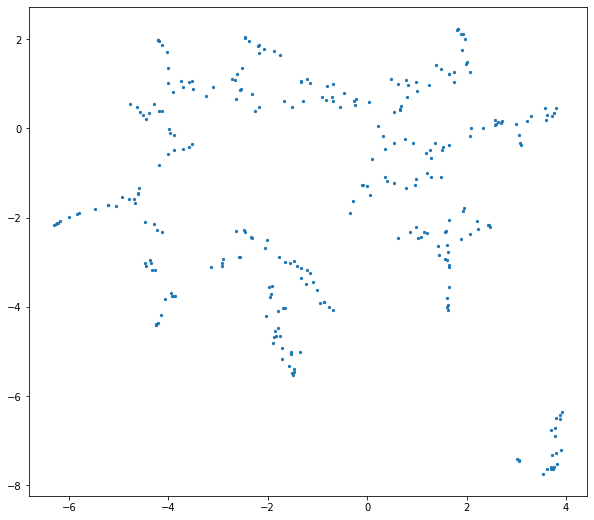

In [221]:
cluster_embedding = reducer.fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1],s=5,cmap='tab10')

In [222]:
len(X)

294

In [223]:
df = pd.DataFrame(cluster_embedding)

In [173]:
#coordinate of fire group
cor_fire = []
for idx in fire_group :
    cor_fire.append(list(cluster_embedding[idx]))
    
    cor_fire_final = [[],[]]
    for i in range(len(cor_fire)) :
        cor_fire_final[0].append(cor_fire[i][0])
        cor_fire_final[1].append(cor_fire[i][1])
        
print(cor_fire_final)


cor_fall = []
for idx in fall_group :
    cor_fall.append(list(cluster_embedding[idx]))
    
    cor_fall_final = [[],[]]
    for i in range(len(cor_fall)) :
        cor_fall_final[0].append(cor_fall[i][0])
        cor_fall_final[1].append(cor_fall[i][1])
        
        
cor_collapse = []
for idx in collapse_group :
    cor_collapse.append(list(cluster_embedding[idx]))
    
    cor_collapse_final = [[],[]]
    for i in range(len(cor_collapse)) :
        cor_collapse_final[0].append(cor_collapse[i][0])
        cor_collapse_final[1].append(cor_collapse[i][1])

cor_last =[]
for idx in last_group :
    cor_last.append(list(cluster_embedding[idx]))
    
    cor_last_final = [[],[]]
    for i in range(len(cor_last)) :
        cor_last_final[0].append(cor_last[i][0])
        cor_last_final[1].append(cor_last[i][1])


[[4.014938, 4.6121507, 3.6270843, 4.59453, 3.9964714, 3.5882874, 2.398462, -0.48929894, 3.5740972, 2.2173972, 4.4995284, 4.2853813, 3.8617992, 4.490687, 4.546338, 4.5793853, 3.90834, 2.27709, 3.141993, 4.168424], [-2.6573176, -3.2462618, -2.2987096, -3.1271484, -2.8773687, -2.4277241, 0.8500761, 2.106132, 0.21952458, 1.069117, -3.2248204, -3.1746058, -0.5868351, -3.2757487, -3.199904, -3.2669544, -3.1063256, 0.99783087, -3.7534256, -0.7724937]]


In [83]:
import pandas as pd

In [224]:
df

,0,1
0,-3.893157,-0.482008
1,0.212397,0.043418
2,-0.288393,-1.619858
3,-4.614486,-1.469546
4,-0.683499,-4.074925
...,...,...
289,-5.475296,-1.815410
290,-6.174657,-2.074453
291,1.602966,-2.948280
292,-6.210297,-2.114630


<function matplotlib.pyplot.show(*args, **kw)>

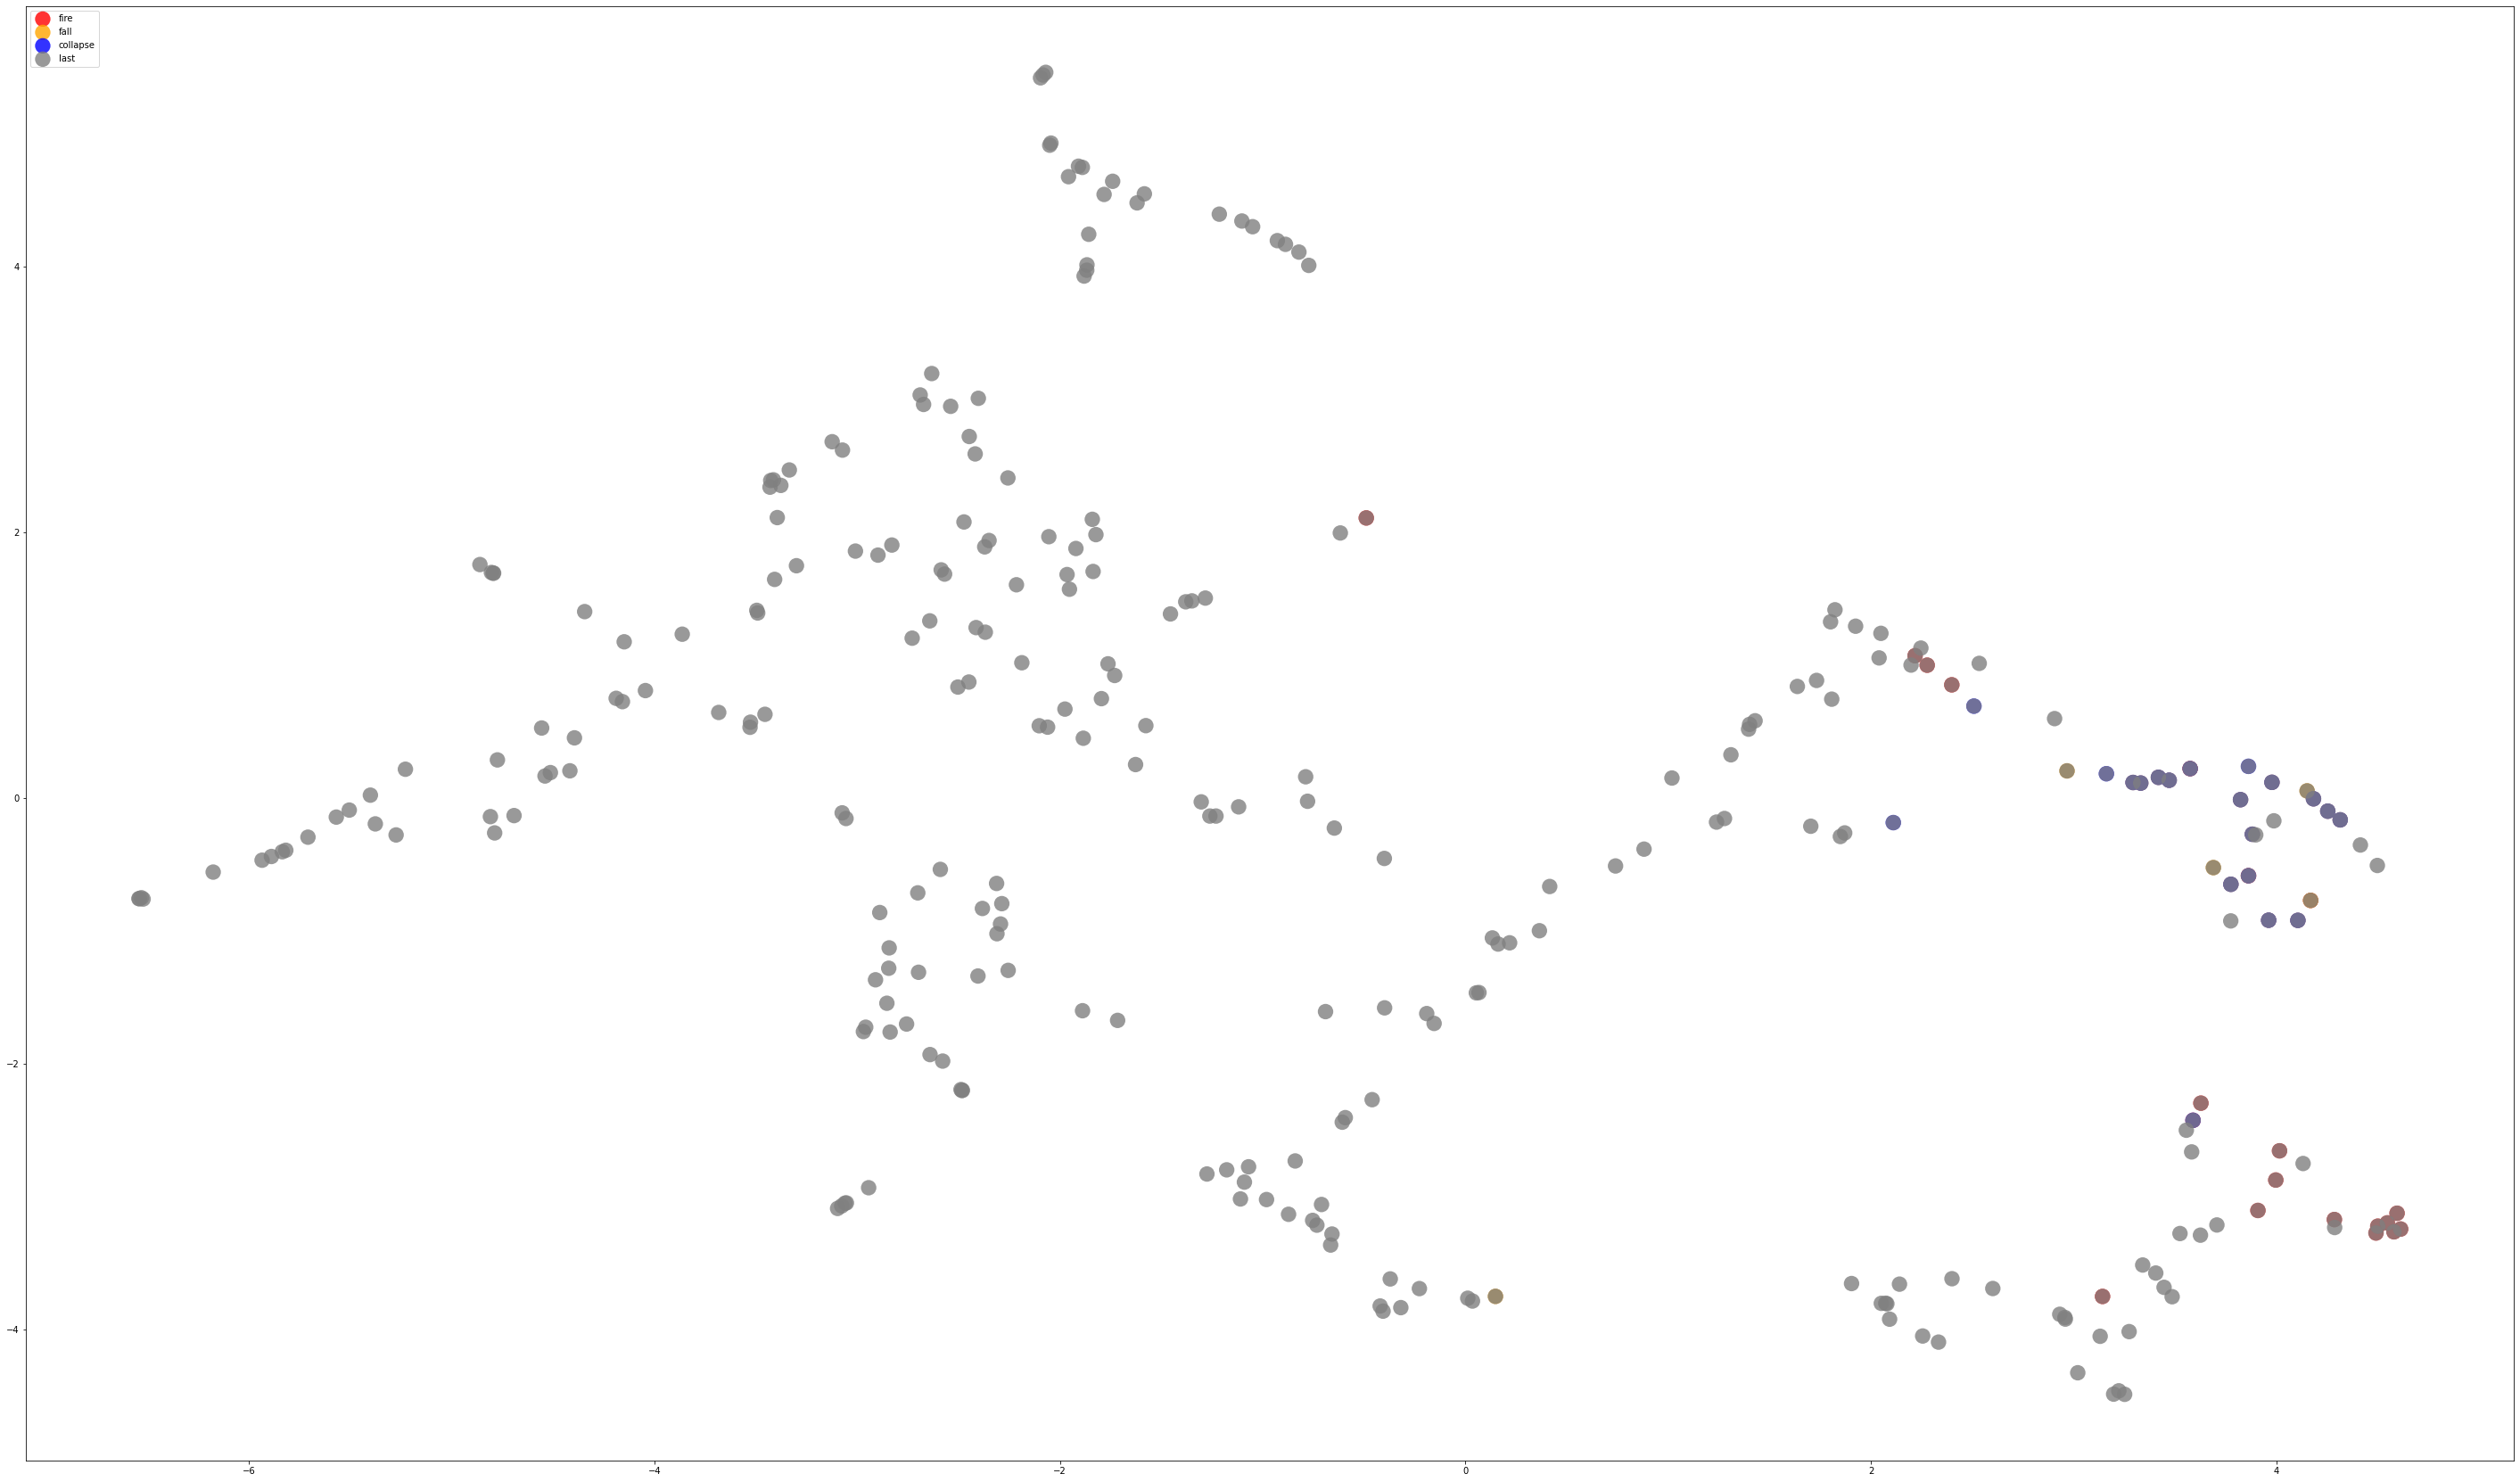

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0, flags=flags)


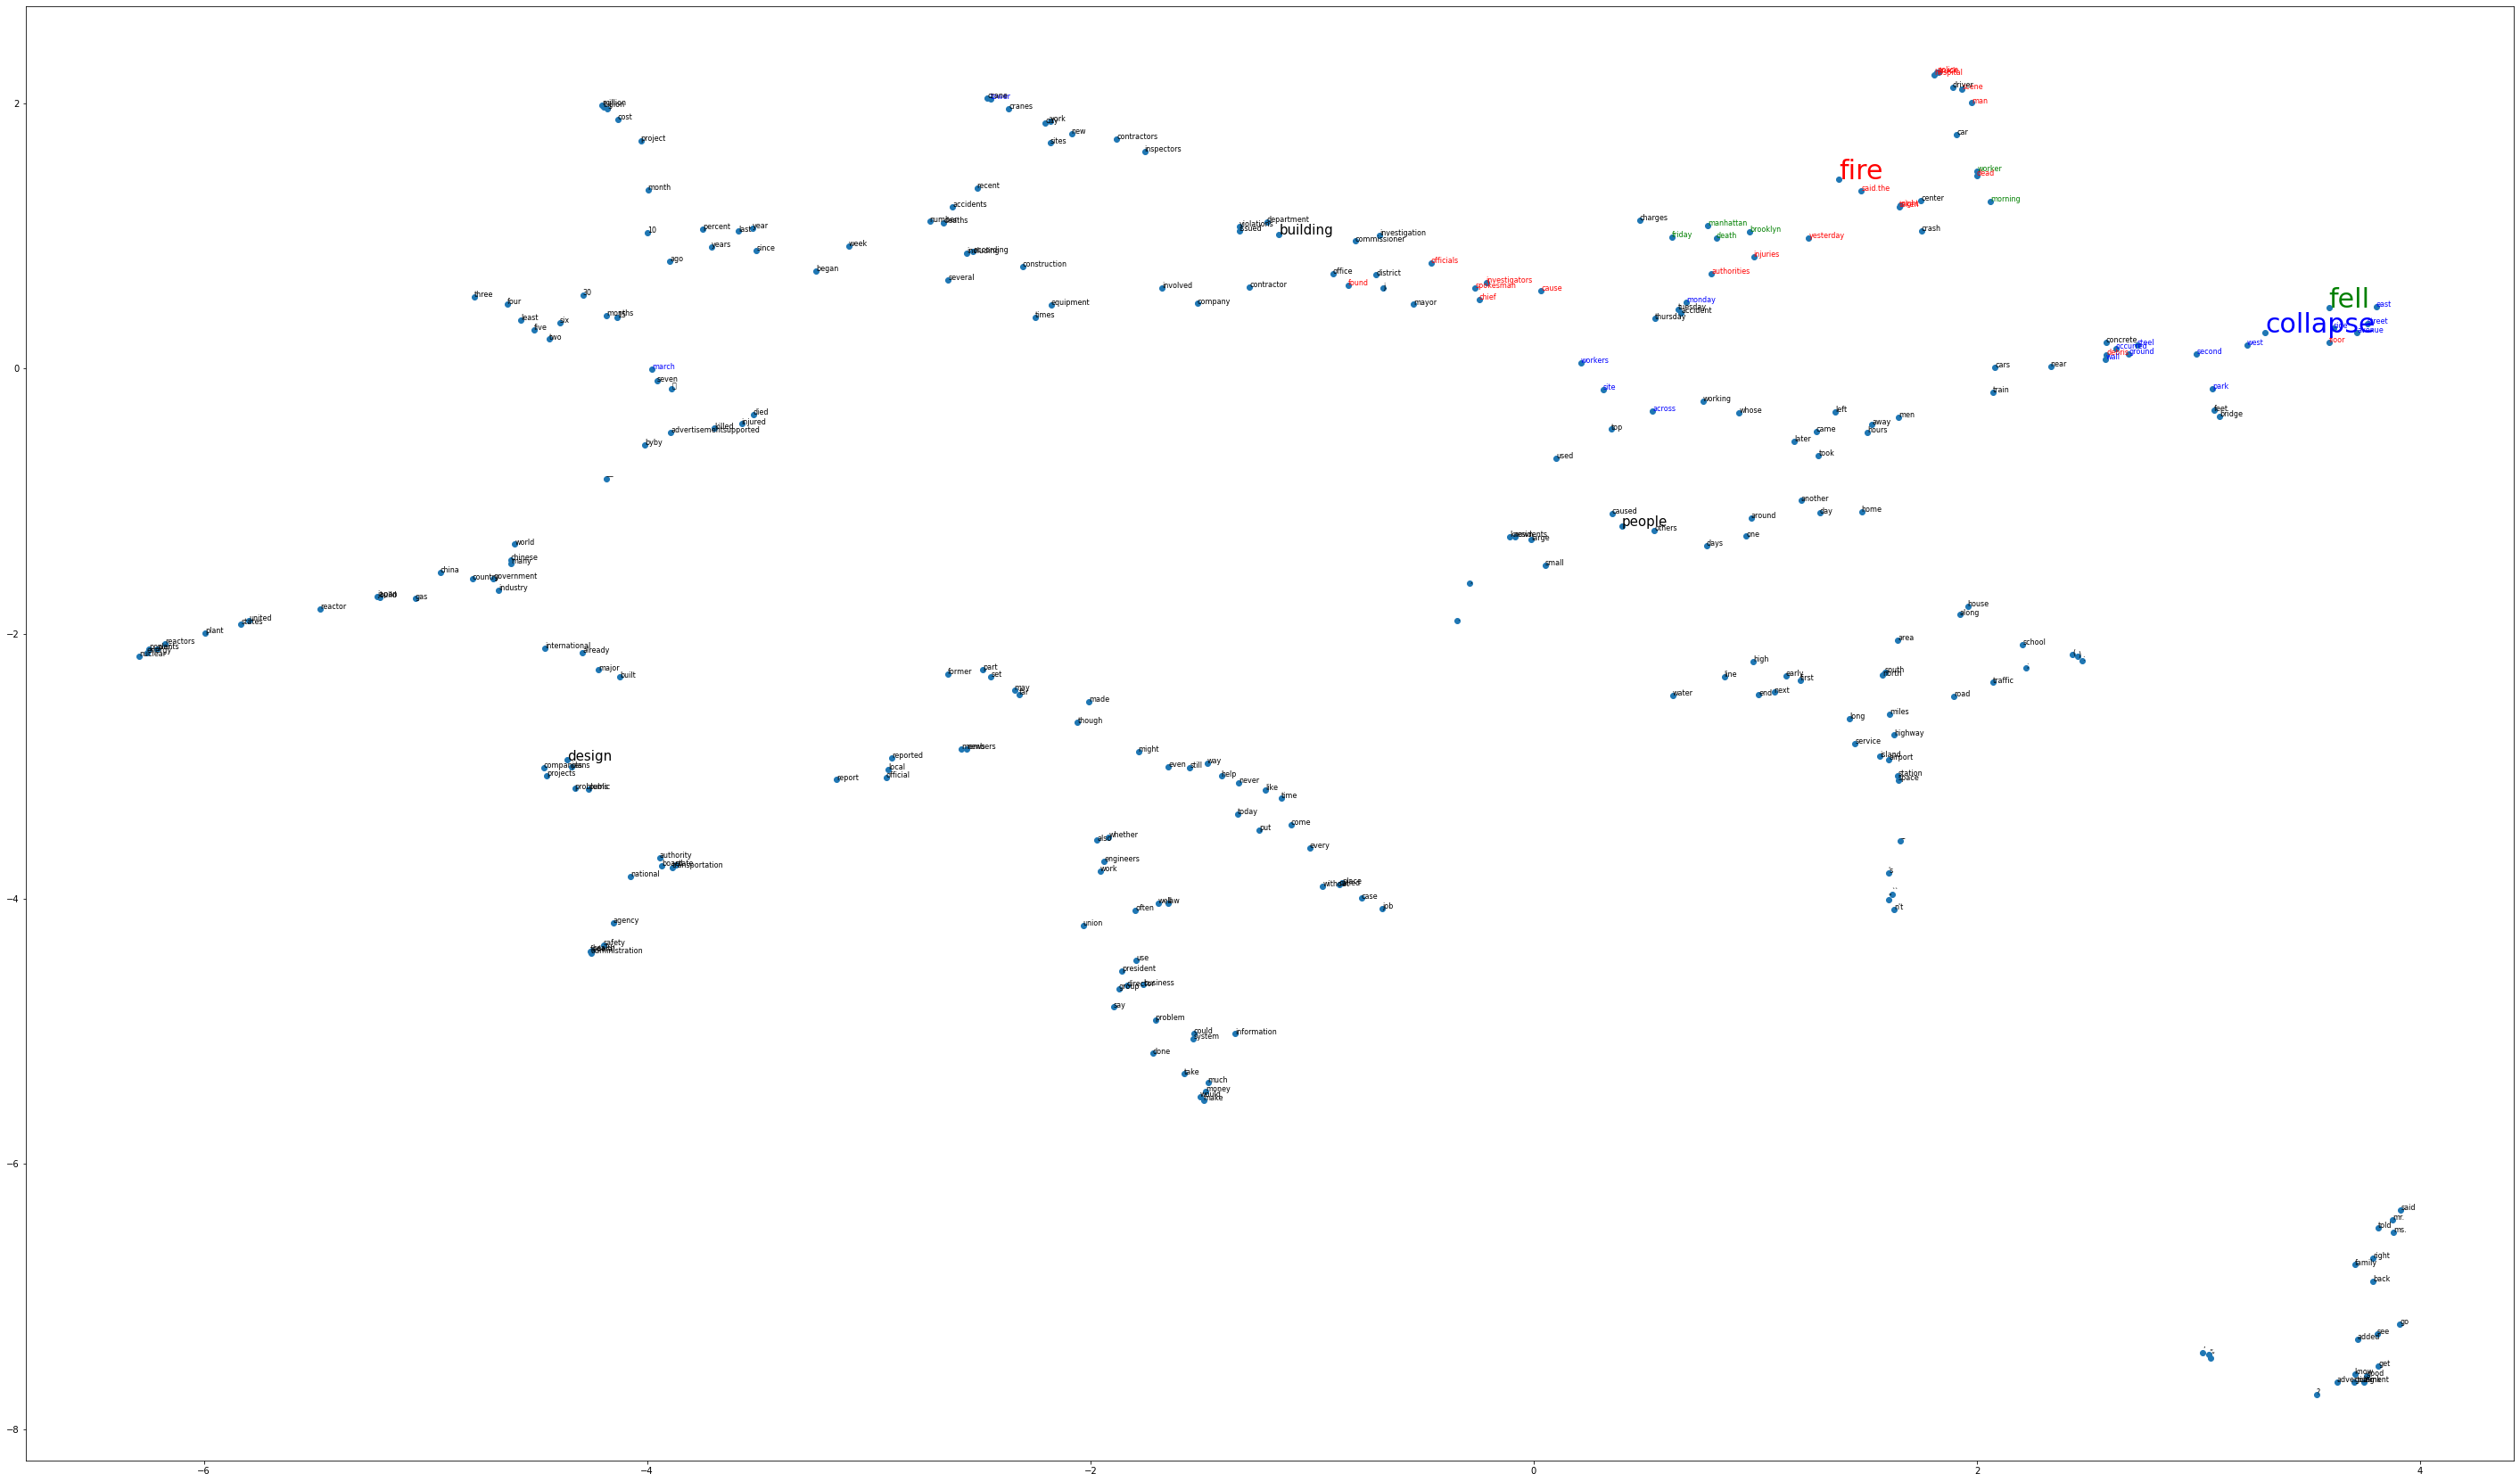

In [225]:
fig = plt.figure()
fig.set_size_inches(50,30)
ax = fig.add_subplot(1,1,1)

ax.scatter(df[0],df[1])

for i, txt in enumerate(X_l):
    
    if txt == 'fire' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'red', fontsize=30)
    elif txt in sim_fire_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='red', fontsize=8)
    elif txt =='fell' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color='green', fontsize=30)
    
    elif txt =='collapse' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'blue', fontsize=30)
    elif txt in sim_collapse_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='blue', fontsize=8)
    elif txt =='building' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)

    elif txt in sim_fall_word :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='green', fontsize=8)        
    elif txt =='people' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='design' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    else :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
#plt.savefig('fire_word2vec.png')

In [453]:
for i, txt in enumerate(X_l) :
    print (i,txt)

In [744]:
X_l

['advertisementsupported',
 'workers',
 ',',
 'many',
 'job',
 'new',
 'york',
 'city',
 'safety',
 'week',
 'accident',
 '’',
 'said',
 'construction',
 'site',
 'working',
 '.',
 'told',
 'years',
 'company',
 'would',
 'another',
 'next',
 '“',
 '”',
 'ms.',
 'killed',
 'floor',
 'building',
 'one',
 'people',
 '10',
 'died',
 'accidents',
 'last',
 'year',
 'according',
 'group',
 'department',
 'buildings',
 'number',
 'deaths',
 'four',
 'death',
 'sites',
 'like',
 'mr.',
 'left',
 '30',
 'percent',
 'union',
 'think',
 'district',
 'contractors',
 'take',
 'issued',
 'work',
 'contractor',
 'also',
 'brooklyn',
 '$',
 'investigation',
 'several',
 'morning',
 'early',
 'make',
 'go',
 'school',
 'three',
 'five',
 'first',
 'day',
 'days',
 'see',
 'said.the',
 'two',
 'family',
 'members',
 'united',
 'states',
 'made',
 'way',
 'time',
 'including',
 'around',
 'involved',
 'second',
 'worker',
 'hours',
 'men',
 'done',
 'help',
 'long',
 'seven',
 'could',
 'scene',
 'proje

In [745]:
df_2 = pd.DataFrame(X_l)

In [746]:
df_2

,0
0,advertisementsupported
1,workers
2,","
3,many
4,job
...,...
284,reactor
285,reactors
286,airport
287,plants


In [748]:
df_2.to_excel('word_list.xlsx')

In [1506]:
with open('word_list.csv', newline='') as csvfile:
    noise_word = csv.reader(csvfile, delimiter =',')
    noise_word_ls = list(noise_word)

print(noise_word_ls)    

remove_list =[]
for i in range(len(noise_word_ls)) :
    remove_list.append(noise_word_ls[i][0])


[['\ufeffadvertisementsupported'], [','], ['’'], ['said'], ['.'], ['told'], ['“'], ['”'], ['ms.'], ['mr.'], ['$'], [';'], ['—'], ['advertisement'], [':'], ['j.'], ['('], [')'], ["'s"], ['``'], ["''"], ["n't"], ['--']]


In [1507]:
remove_list

['\ufeffadvertisementsupported',
 ',',
 '’',
 'said',
 '.',
 'told',
 '“',
 '”',
 'ms.',
 'mr.',
 '$',
 ';',
 '—',
 'advertisement',
 ':',
 'j.',
 '(',
 ')',
 "'s",
 '``',
 "''",
 "n't",
 '--']

In [1372]:
len(remove_list)

24

In [147]:
N = 60
g1 = (0.6 + 0.6 * np.random.rand(N), np.random.rand(N))

In [148]:
g1

(array([0.97150155, 1.17576245, 1.10800402, 0.79778908, 1.0974764 ,
        0.83931285, 0.81895679, 1.09564221, 0.84127895, 0.89681074,
        0.81475197, 0.96524666, 0.6631429 , 1.13537171, 1.02697847,
        1.13486616, 0.71740953, 1.09708944, 1.13590244, 0.82585905,
        0.98767093, 0.65104976, 0.69225685, 0.70553657, 0.61660734,
        1.18211938, 0.62798259, 0.87710554, 1.15736854, 1.09136374,
        0.75122647, 0.97098216, 0.68860313, 1.07950149, 0.90341855,
        1.18663693, 1.17955985, 0.93161038, 1.18717579, 0.63051869,
        0.73454973, 1.19725139, 1.03688112, 0.75249551, 0.67120233,
        1.14728345, 0.63952431, 0.73362781, 0.92395611, 0.96617451,
        0.70746697, 0.72722546, 1.04557784, 0.71999417, 1.1300056 ,
        0.70484132, 0.7625674 , 1.18612382, 0.9604383 , 0.9904802 ]),
 array([0.02422418, 0.04546603, 0.33568903, 0.9997002 , 0.67546431,
        0.50027817, 0.0667582 , 0.85634162, 0.05426195, 0.49864079,
        0.21986576, 0.48708821, 0.56449205, 0.

In [149]:
a = [[],[]]

In [151]:
a[1]

[]

In [ ]:
fig = plt.figure()
fig.set_size_inches(50,30)
ax = fig.add_subplot(1,1,1)
colors =('red','orange','blue','gray')
data = (cor_fire_final, cor_fall_final, cor_collapse_final, cor_last_final)
groups = ('fire', 'fall', 'collapse', 'last')

for data, color, group in zip (data, colors, groups):
    x,y = data
    ax.scatter(x,y,alpha= 0.8, c= color, edgecolors ='none', s= 300, label = group)

plt.legend(loc=2)
plt.show
#ax.scatter(df[0],df[1], color = colors, label = groups)

